# EDA which makes sense

This notebook analyzes the competition data and gives insight on how to proceed with modeling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from cycler import cycler
from IPython import display
import datetime

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])

# Reading the data

In [2]:
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col='row_id', parse_dates=['time'])
test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col='row_id', parse_dates=['time'])

print(train.shape, test.shape)
train.head()

(848835, 5) (2340, 4)


,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01,0,0,EB,70
1,1991-04-01,0,0,NB,49
2,1991-04-01,0,0,SB,24
3,1991-04-01,0,1,EB,18
4,1991-04-01,0,1,NB,60


# Geography

There are 12 roadways, 8 directions and 65 combinations of roadway with direction. This means that on average, a roadway has between 5 and 6 directions. The code below shows this for the training data; the test data has the same geography. There are no missing values here.

In [3]:
# Unique roadways
roadways = train[['x', 'y']].drop_duplicates()
display.display(roadways)

# Unique directions
print('Unique directions:', train.direction.unique())

# Unique roadways with direction
road_dir = train[['x', 'y', 'direction']].drop_duplicates()
display.display(road_dir)


,x,y
row_id,,
0,0,0
3,0,1
7,0,2
11,0,3
17,1,0
23,1,1
27,1,2
33,1,3
39,2,0


Unique directions: ['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']


,x,y,direction
row_id,,,
0,0,0,EB
1,0,0,NB
2,0,0,SB
3,0,1,EB
4,0,1,NB
...,...,...,...
60,2,3,NB
61,2,3,NE
62,2,3,SB


We can plot a geographical map of the 12 places with the directions:

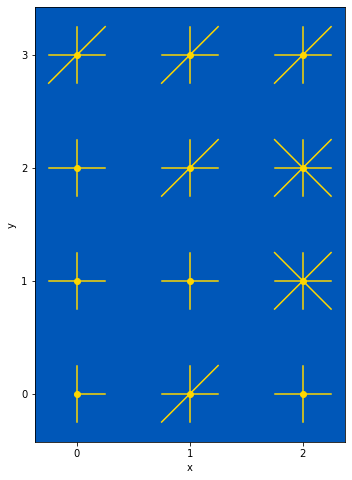

In [4]:
dir_dict = {'EB': (1, 0), 'NB': (0, 1), 'SB': (0, -1), 'WB': (-1, 0), 'NE': (1, 1), 'SE': (-1, 1), 'NW': (1, -1), 'SW': (-1, -1)}

plt.figure(figsize=(8, 8))
plt.scatter(roadways.x, roadways.y)
plt.gca().set_aspect('equal')
for _, x, y, d in road_dir.itertuples():
    dx, dy = dir_dict[d]
    dx, dy = dx/4, dy/4
    plt.plot([x, x+dx], [y, y+dy], color='#ffd700')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
plt.xlabel('x')
plt.ylabel('y')
plt.show()

**Insight:**
- As congestion is measured for certain points and directions in space, we can expect that these congestions predict future congestion at the nearest point in the given direction. For instance, congestion at (0, 1, eastbound) should be correlated with future congestion at (1, 1, ...).
- The correlation goes both ways so that we can try to predict backwards: congestion at (1, 1, eastbound) should be correlated with past congestion at (0, 1, ...).
- At first sight, it is unclear whether we need the geography at all: A simple approach for the competition would be ignoring the geography and creating 65 independent time series.
- Another simple approach is one-hot encoding the 65 position/direction combinations and using them as features.
- Although the y coordinate in the diagram grows from bottom to top (south to north), we can't take this for granted. Maybe it should grow from top to bottom.

# Time

There are 13059 time values in the training data. As 13059 * 65 = 848835, i.e. the length of the `train` dataframe, we know that at every point in time, the congestion is known for all 65 roadways.

In [5]:
unique_times = train.time.unique()
print(unique_times.shape)

(13059,)


All training timestamps are between 1991-04-01 00:00 and 1991-09-30 11:40. The test timestamps cover the half day from 1991-09-30 12:00 through 1991-09-30 23:40, which is a Monday.

The difference between successive training timestamps is almost always 20 minutes, except for the 28 timestamps in the following list:

In [6]:
print(unique_times.min(), unique_times.max())
print(test.time.min(), test.time.max())
print(np.diff(unique_times)[0])
unique_times[1:][np.diff(unique_times) != np.diff(unique_times)[0]]

1991-04-01T00:00:00.000000000 1991-09-30T11:40:00.000000000
1991-09-30 12:00:00 1991-09-30 23:40:00
1200000000000 nanoseconds


array(['1991-04-20T19:20:00.000000000', '1991-04-24T06:20:00.000000000',
       '1991-05-04T22:00:00.000000000', '1991-05-18T19:40:00.000000000',
       '1991-05-31T03:20:00.000000000', '1991-06-15T20:40:00.000000000',
       '1991-07-18T20:20:00.000000000', '1991-07-20T19:40:00.000000000',
       '1991-08-08T14:20:00.000000000', '1991-08-16T19:00:00.000000000',
       '1991-08-17T19:40:00.000000000', '1991-08-23T15:20:00.000000000',
       '1991-08-23T16:00:00.000000000', '1991-08-27T12:00:00.000000000',
       '1991-08-29T03:40:00.000000000', '1991-08-29T09:20:00.000000000',
       '1991-08-30T14:20:00.000000000', '1991-08-31T11:00:00.000000000',
       '1991-09-12T03:20:00.000000000', '1991-09-12T08:20:00.000000000',
       '1991-09-12T11:00:00.000000000', '1991-09-17T14:00:00.000000000',
       '1991-09-18T14:40:00.000000000', '1991-09-19T03:20:00.000000000',
       '1991-09-19T08:40:00.000000000', '1991-09-21T22:00:00.000000000',
       '1991-09-24T09:40:00.000000000', '1991-09-24

**Insight:**
- There are missing values, and our training algorithm will have to deal with a noncontiguous time series.
- As the test set is restricted to one Monday afternoon, perhaps we don't need to model the other days of the week. Maybe we can create a model which takes 6½ days from Tuesday morning until Monday noon as input and predicts Monday afternoon.

# Congestion and its special values

The congestion values are integers between 0 and 100 (inclusive). 

**Insight:** As most regression algorithms output float values, we will have to clip and round the regression output (see discussion post [Why rounding improves the score](https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/301249)).

In [7]:
np.unique(train.congestion)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

The histogram shows a Gaussian distribution with an overlay of certain values which occur much more often than their neighbors. The most prominent values are 15, 20, 21, 29, 34. 


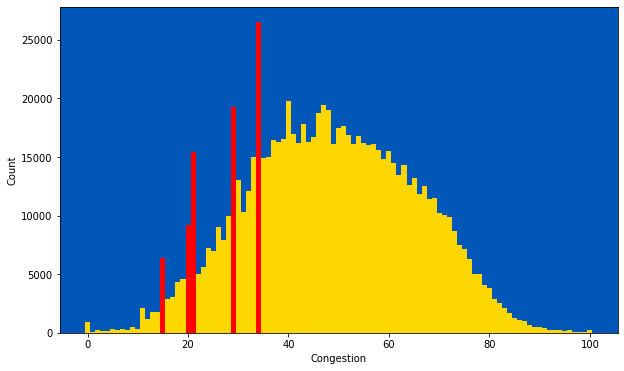

In [8]:
plt.figure(figsize=(10, 6))
#plt.hist(train.congestion, bins=np.linspace(-0.5, 100.5, 102))
plt.bar(range(101), train.congestion.value_counts().sort_index(), width=1,
        color=['r' if con in [15, 20, 21, 29, 34] else '#ffd700' for con in range(101)])
plt.ylabel('Count')
plt.xlabel('Congestion')
plt.show()


**Insight:**
- We need a deeper analysis in what contexts the values 15, 20, 21, 29, 34 are overrepresented.
- It will be difficult to model this overrepresentation with a regression model. Maybe we need to invent special tricks to predict these values (if it is possible at all).

Let's drill down into some roadways to see whether the same values are overrepresented everywhere.

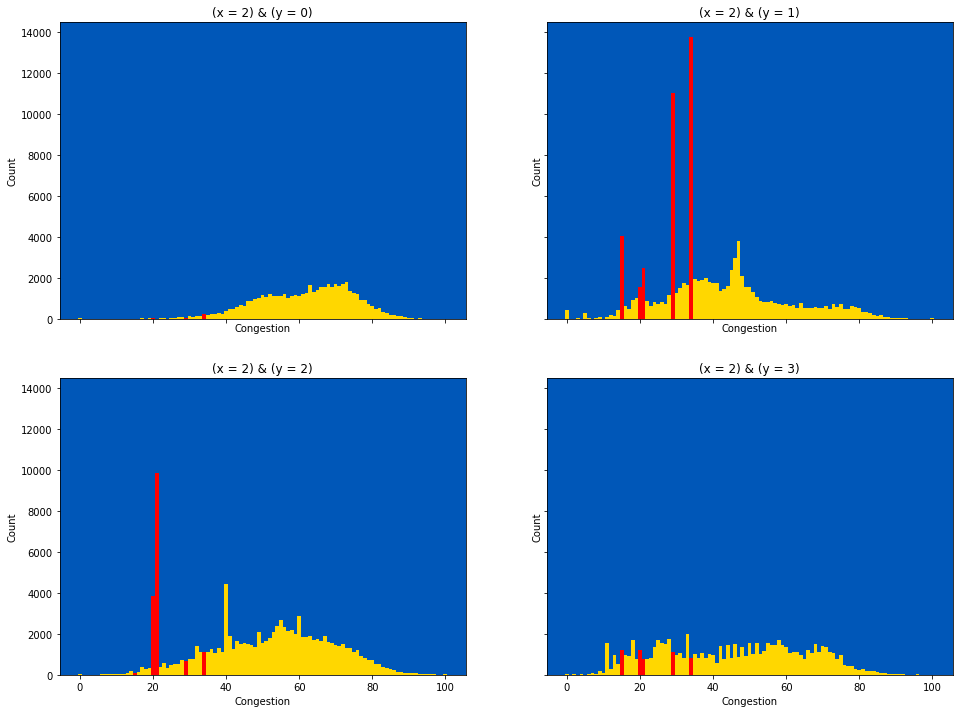

In [9]:
plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))
for y in range(4):
    plt.subplot(2, 2, y+1)
    vc = train[(train.x == 2) & (train.y == y)].congestion.value_counts().sort_index()
    plt.bar(vc.index, vc, width=1,
            color=['r' if con in [15, 20, 21, 29, 34] else '#ffd700' for con in vc.index])
    plt.ylabel('Count')
    plt.xlabel('Congestion')
    plt.title(f"(x = {2}) & (y = {y})")
plt.show()

Obviously, congestions 15, 29 and 34 are a particularity of the roadway with x = 2 and y = 1. We'll drill down further, into the eight directions of this roadway, plotting all congestion values on a time axis, just to see that some of the directions have these special congestion values on every day of the six months of training data. 

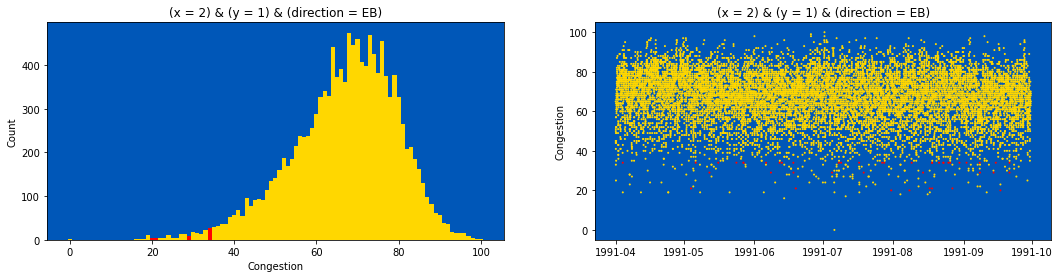

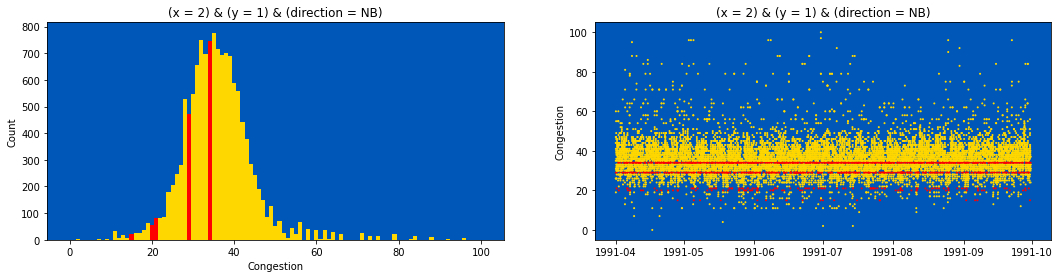

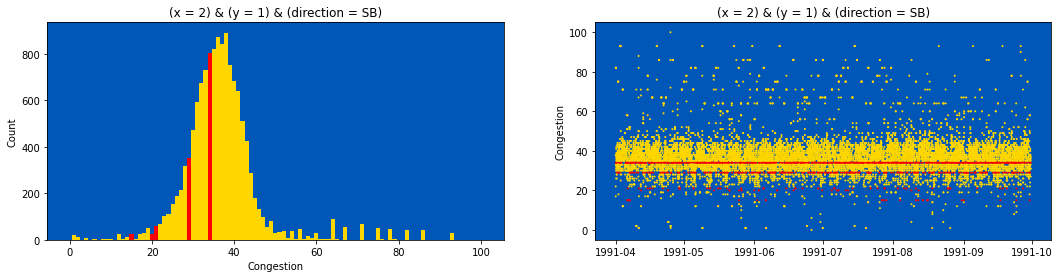

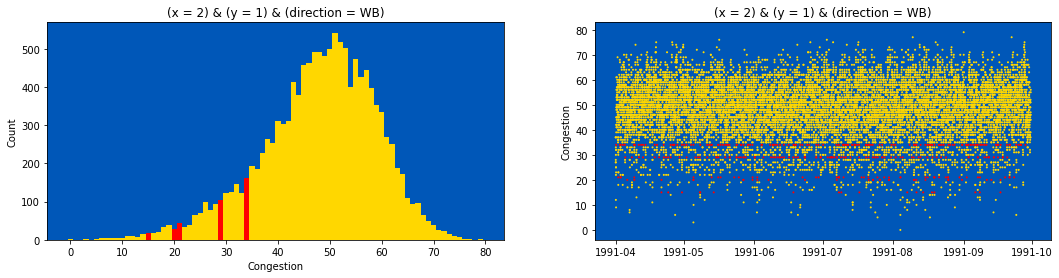

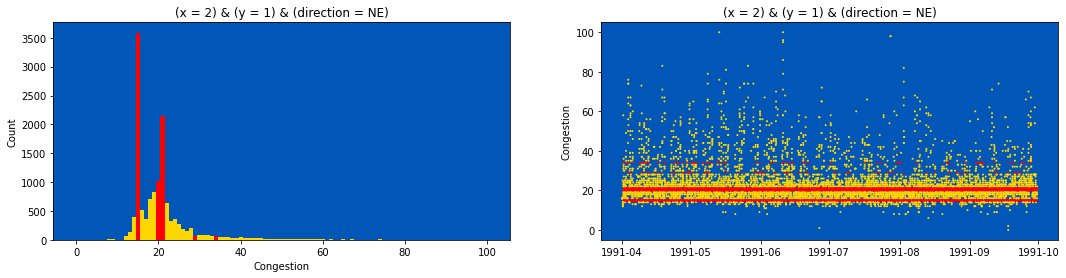

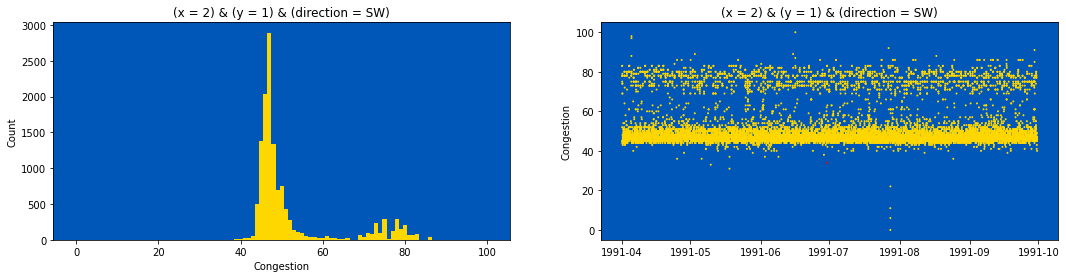

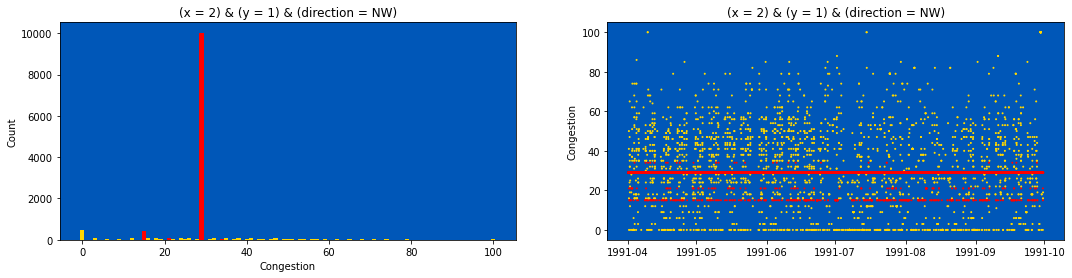

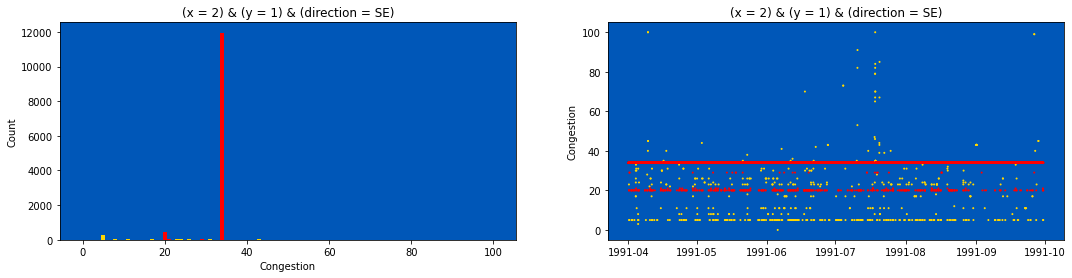

In [10]:
for direction in train.direction.unique():
    temp = train[(train.x == 2) & (train.y == 1) & (train.direction == direction)]
    plt.subplots(1, 2, figsize=(18, 4))
    plt.subplot(1, 2, 1)
    vc = temp.congestion.value_counts().sort_index()
    plt.bar(vc.index, vc, width=1,
            color=['r' if con in [15, 20, 21, 29, 34] else '#ffd700' for con in vc.index])
    plt.ylabel('Count')
    plt.xlabel('Congestion')
    plt.title(f"(x = {2}) & (y = {1}) & (direction = {direction})")
    plt.subplot(1, 2, 2)
    plt.scatter(temp.time, temp.congestion, s=1, color=['r' if con in [15, 20, 21, 29, 34] else '#ffd700' for con in temp.congestion])
    plt.title(f"(x = {2}) & (y = {1}) & (direction = {direction})")
    plt.ylabel('Congestion')
    plt.show()

**Insight:** At this level of detail, the dataset no longer looks like something which a linear regression can fit. Decision trees may be the better choice for these data.

# Dependence on time and date

We start by looking for a weekly pattern. As was to be expected, there is less traffic on weekends.

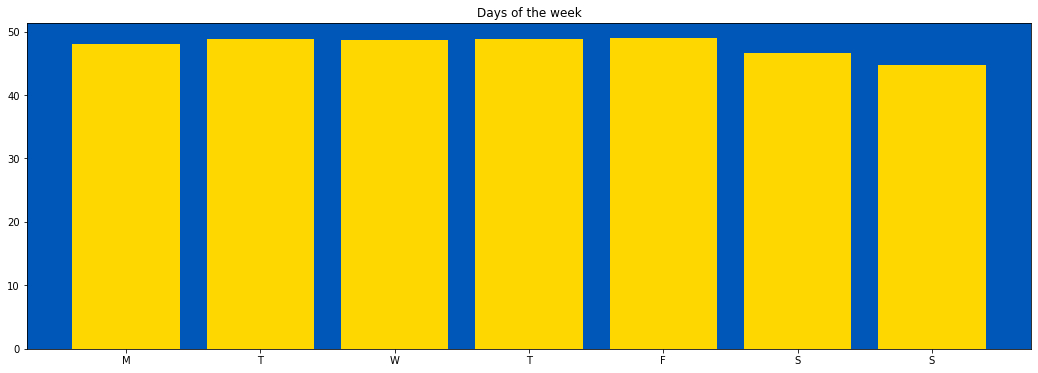

In [11]:
temp = train.groupby(train.time.dt.dayofweek).congestion.mean()
plt.figure(figsize=(18, 6))
plt.title('Days of the week')
plt.bar(temp.index, temp, color='#ffd700')
plt.xticks(ticks=temp.index, labels='MTWTFSS')
plt.show()

What about a daily pattern? There is a daily pattern with a morning peak and a higher peak in the late afternoon.

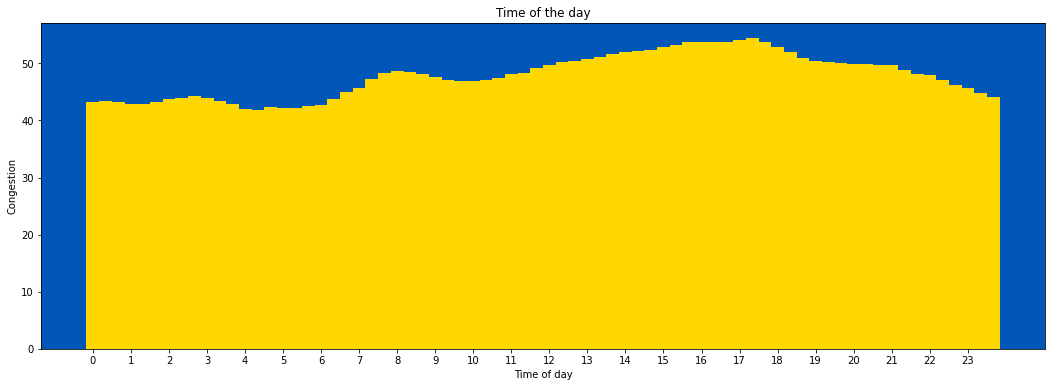

In [12]:
temp = train.groupby(train.time.dt.hour + train.time.dt.minute/60).congestion.mean()
plt.figure(figsize=(18, 6))
plt.title('Time of the day')
plt.bar(temp.index, temp, color='#ffd700', width=0.34)
plt.xticks(range(24))
plt.xlabel('Time of day')
plt.ylabel('Congestion')
plt.show()

Drilling down we see that every road has its own daily pattern:

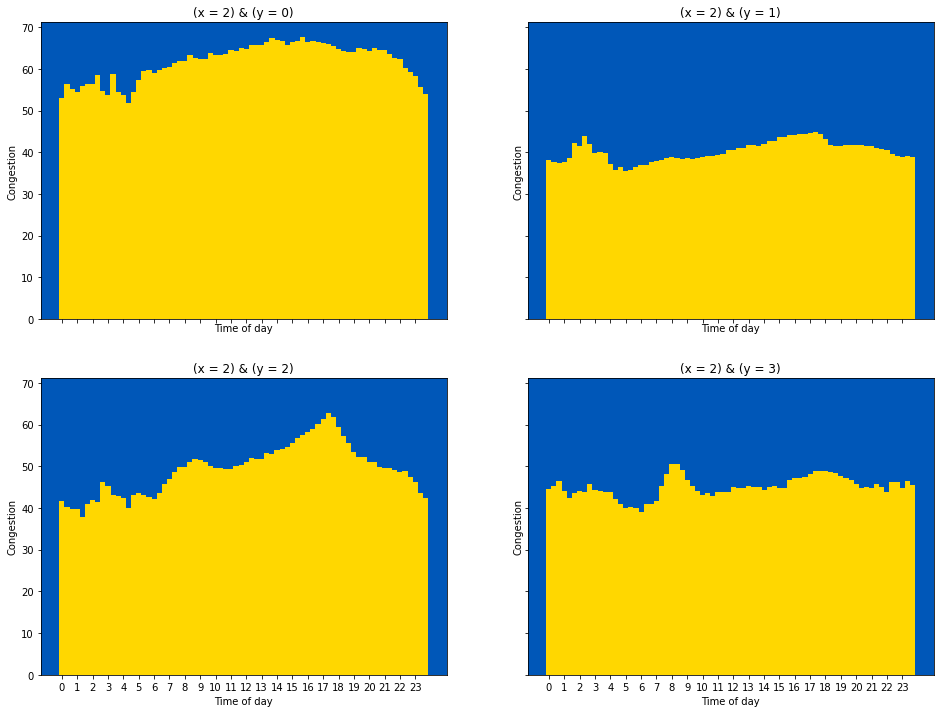

In [13]:
plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))
for y in range(4):
    plt.subplot(2, 2, y+1)
    vc = train[(train.x == 2) & (train.y == y)]
    temp = vc.groupby(vc.time.dt.hour + vc.time.dt.minute/60).congestion.mean()
    plt.bar(temp.index, temp, color='#ffd700', width=0.34)
    plt.xticks(range(24))
    plt.xlabel('Time of day')
    plt.ylabel('Congestion')
    plt.title(f"(x = {2}) & (y = {y})")
plt.show()

If we plot the daily values for all days of the summer of 1991, we see more fluctuations:
- The last week of April (the fifth week of the diagram) has exceptionally high traffic.
- May 27 (Memorial Day) is a long weekend with little traffic on Monday.
- The fourth of July (which was a Thursday) has exceptionally low traffic.
- Labor day (September 2, the first Monday of September) has exceptionally low traffic.
- The last two weekends in September look strange. Friday September 27 has very high traffic.
- The rightmost bar of the diagram (Monday September 30) is quite low. This can probably be explained because the training data contains only the morning of this day (the afternoon is the test data).
- Overall, there seem to be week with high traffic and weeks with low traffic.

(I used [this calendar](https://www.timeanddate.com/calendar/?year=1991&country=1) for looking up the holidays.)

**Insight:**
- We will have to deal with outliers. A simple approach is dropping all the holidays before training.
- If morning and afternoon of the same day are correlated, the morning of September 30 will play a special role in predicting the test afternoon.
- We may need to find suitable external data to explain the high and low traffic weeks.
- The worst case for our predictions will be if September 30 is a holiday or there is a big event which changes the traffic patterns.
- A good validation strategy will be important. Perhaps we can use a few Monday afternoons as validation set.

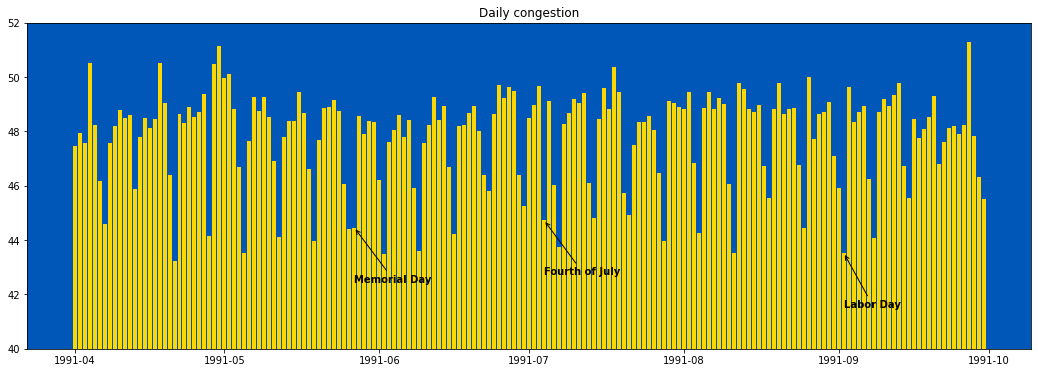

In [14]:
temp = train.groupby(train.time.dt.date).congestion.mean()
plt.figure(figsize=(18, 6))
plt.title('Daily congestion')
plt.bar(temp.index, temp, color='#ffd700')
plt.ylim(40, 52)
for holiday_name, month, day in [('Memorial Day', 5, 27), ('Fourth of July', 7, 4), ('Labor Day', 9, 2)]:
    date = datetime.date(1991, month, day)
    plt.annotate(holiday_name,
                 (np.datetime64(date), temp.loc[date]),
                 xytext=(np.datetime64(date), temp.loc[date]-2),
                 arrowprops={'arrowstyle': '->'},
                 weight='bold',
                 color='k')
plt.show()

# Trend

We ca fit a linear regression to the daily averages to see if there is any significant growth during the six months. The diagram shows that the congestion grows by less than 0.2 over the whole period. I cannot yet tell whether this growth is significant.

**Insight:** 
- Considering that the total growth amounts to 0.2 and we are predicting integers, we may neglect growth for the beginning.
- Before we include the trend as a feature in a model, we should test its significance. 

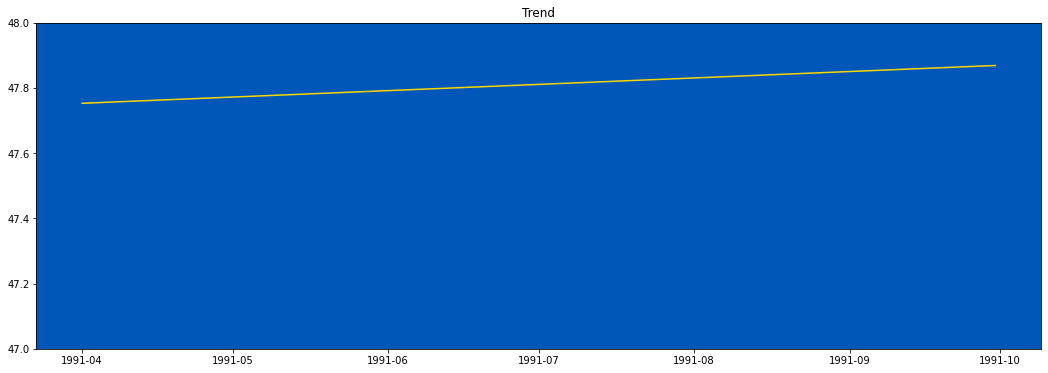

In [15]:
temp = train.groupby(train.time.dt.date).congestion.mean()
plt.figure(figsize=(18, 6))
plt.title('Trend')
poly = np.polynomial.polynomial.Polynomial.fit(range(len(temp.index)), temp, deg=1)
plt.plot(temp.index, poly(range(len(temp.index))))
plt.ylim(47, 48)
plt.show()


# Conclusion

This will be an interesting competition!